In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import matplotlib.pyplot as plt
import zipfile
import os
import pandas as pd
from PIL import Image


In [2]:
# Step 1: Define ConvNet3 and ConvNet7 Models
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 28 * 28, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        return x

class ConvNet7(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNet7, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# Step 2: Import Libraries and Define Data Transformations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Step 3: File Upload and Extraction
#  ZIP 文件已上传至 /content/mhist_dataset 文件夹下的 images.zip
mhist_zip_path = '/content/mhist_dataset/images.zip'
mhist_extract_path = '/content/mhist_dataset/images'
# 解压 MHIST ZIP 文件
with zipfile.ZipFile(mhist_zip_path, 'r') as zip_ref:
    zip_ref.extractall(mhist_extract_path)


In [4]:
# Step 4: Load MNIST Dataset for Standard Training
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
test_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)

train_loader_mnist = DataLoader(mnist_dataset, batch_size=256, shuffle=True)
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=256, shuffle=False)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.92MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
# 自定义 MHIST 数据集类
class MHISTDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label_text = self.img_labels.iloc[idx, 1]
        # 将标签转换为整数 (例如 'HP' -> 0, 'SSA' -> 1)
        if label_text == 'HP':
            label = 0
        elif label_text == 'SSA':
            label = 1
        else:
            raise ValueError(f"Unexpected label value: {label_text}")

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
# MHIST 数据集路径
annotations_file = '/content/mhist_dataset/annotations.csv'
img_dir = '/content/mhist_dataset/images/images'

In [8]:
# 设置 MHIST 数据集的预处理
mhist_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 适用于单通道的灰度图像
])

In [10]:
# 加载 MHIST 数据集
mhist_dataset = MHISTDataset(annotations_file=annotations_file, img_dir=img_dir, transform=mhist_transform)
train_loader_mhist = DataLoader(mhist_dataset, batch_size=128, shuffle=True)

In [12]:
# Step 5: Define Model, Loss, and Optimizer for Standard Training
model_mnist = ConvNet3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_mnist = optim.SGD(model_mnist.parameters(), lr=0.01, momentum=0.9)

# Train the model on full dataset
def train_model(model, data_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(data_loader):
            try:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            except Exception as e:
                continue

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(data_loader)}")

def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total}%")

train_model(model_mnist, train_loader_mnist, criterion, optimizer_mnist, epochs=20)
evaluate_model(model_mnist, test_loader_mnist)

Epoch 1/20, Loss: 0.4237774615275099
Epoch 2/20, Loss: 0.10512658574796738
Epoch 3/20, Loss: 0.07719120625010197
Epoch 4/20, Loss: 0.06421299289832724
Epoch 5/20, Loss: 0.055160521866476284
Epoch 6/20, Loss: 0.04998793526691325
Epoch 7/20, Loss: 0.04470214076102414
Epoch 8/20, Loss: 0.04080028710292375
Epoch 9/20, Loss: 0.03644721021558693
Epoch 10/20, Loss: 0.033451840630237095
Epoch 11/20, Loss: 0.03231159755761953
Epoch 12/20, Loss: 0.02801815800844355
Epoch 13/20, Loss: 0.025140646985791465
Epoch 14/20, Loss: 0.02300505110240997
Epoch 15/20, Loss: 0.021507106925499567
Epoch 16/20, Loss: 0.019467514273809626
Epoch 17/20, Loss: 0.017089782562602233
Epoch 18/20, Loss: 0.01659865114996408
Epoch 19/20, Loss: 0.015350785812343214
Epoch 20/20, Loss: 0.013479564159593366
Test Accuracy: 98.52%


In [13]:
# Step 6: Train ConvNet-7 on MHIST Dataset
model_mhist = ConvNet7().to(device)
optimizer_mhist = optim.SGD(model_mhist.parameters(), lr=0.01, momentum=0.9)

train_model(model_mhist, train_loader_mhist, criterion, optimizer_mhist, epochs=20)
evaluate_model(model_mhist, train_loader_mhist)

Epoch 1/20, Loss: 0.6259890031814576
Epoch 2/20, Loss: 0.5974159550666809
Epoch 3/20, Loss: 0.575531678199768
Epoch 4/20, Loss: 0.5547896683216095
Epoch 5/20, Loss: 0.5286800253391266
Epoch 6/20, Loss: 0.5144336974620819
Epoch 7/20, Loss: 0.4903003227710724
Epoch 8/20, Loss: 0.48177984833717347
Epoch 9/20, Loss: 0.46445379734039305
Epoch 10/20, Loss: 0.46361841320991515
Epoch 11/20, Loss: 0.4461985862255096
Epoch 12/20, Loss: 0.43523722648620605
Epoch 13/20, Loss: 0.4127389872074127
Epoch 14/20, Loss: 0.4103913390636444
Epoch 15/20, Loss: 0.42518157720565797
Epoch 16/20, Loss: 0.37980807542800904
Epoch 17/20, Loss: 0.357821592092514
Epoch 18/20, Loss: 0.3462432527542114
Epoch 19/20, Loss: 0.3318899065256119
Epoch 20/20, Loss: 0.27736255824565886
Test Accuracy: 90.98984771573605%


In [34]:
pip install fvcore


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=41b6796f3288c2f126dc5a1add0976847af775b0047abedff4906806676b3425
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=f821d2e53d0985c79d362f0500f048fc6e4311342e09a755bf02eee5bcee9760
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
from fvcore.nn import FlopCountAnalysis
import torch

# 假设 ConvNet3 和 ConvNet7 已定义

# Step 1: 定义模型
model_convnet3 = ConvNet3().to(device)
model_convnet7 = ConvNet7().to(device)

# Step 2: 计算并打印 FLOPs
input_tensor = torch.randn(1, 1, 28, 28).to(device)  # 输入张量，假设 MNIST 或 MHIST 图像大小为 1x28x28
flop_counter_convnet3 = FlopCountAnalysis(model_convnet3, input_tensor)
print(f"ConvNet3 FLOPs: {flop_counter_convnet3.total()}")

flop_counter_convnet7 = FlopCountAnalysis(model_convnet7, input_tensor)
print(f"ConvNet7 FLOPs: {flop_counter_convnet7.total()}")


In [18]:
######################
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [19]:
# Step 1: 从真实数据中初始化蒸馏图像
def initialize_from_real_data(data_loader, num_classes, num_images_per_class):
    """
    从真实数据集中随机选择每个类别的图像来初始化蒸馏图像。
    """
    real_images = []
    real_labels = []
    for class_idx in range(num_classes):
        count = 0
        for images, labels in data_loader:
            mask = (labels == class_idx)
            selected_images = images[mask]
            if selected_images.size(0) > 0:
                real_images.append(selected_images[:num_images_per_class])
                real_labels.extend([class_idx] * min(num_images_per_class, selected_images.size(0)))
                count += selected_images.size(0)
            if count >= num_images_per_class:
                break
    real_images = torch.cat(real_images).to(device)
    real_labels = torch.tensor(real_labels).to(device)
    return real_images, real_labels

# 初始化蒸馏图像和标签
num_classes = 2  # 假设 MHIST 是二分类问题
num_images_per_class = 10  # 每个类别的蒸馏图像数量
distilled_images, distilled_labels = initialize_from_real_data(train_loader_mhist, num_classes, num_images_per_class)
distilled_images.requires_grad = True
lr_image = 0.1  # 蒸馏图像的学习率
optimizer_images = optim.SGD([distilled_images], lr=lr_image)

In [20]:
# Step 2: 使用 Attention Matching 进行数据蒸馏
def distill_with_attention_matching(model, data_loader, distilled_images, distilled_labels, optimizer_images, T=10):
    """
    基于 Attention Matching 进行数据蒸馏。

    参数:
        model: torch.nn.Module - 在 MHIST 数据集上训练好的模型。
        data_loader: DataLoader - MHIST 数据的 DataLoader。
        distilled_images: torch.Tensor - 蒸馏图像数据。
        distilled_labels: torch.Tensor - 蒸馏图像标签。
        optimizer_images: torch.optim.Optimizer - 用于更新蒸馏图像的优化器。
        T: int - 蒸馏过程的迭代次数。
    """
    model.eval()
    for t in range(T):
        total_loss = 0.0
        for real_images, real_labels in data_loader:
            real_images, real_labels = real_images.to(device), real_labels.to(device)

            optimizer_images.zero_grad()
            with torch.no_grad():
                real_outputs = model(real_images)
                real_loss = F.cross_entropy(real_outputs, real_labels)

            synthetic_outputs = model(distilled_images)
            synthetic_loss = F.cross_entropy(synthetic_outputs, distilled_labels)
            synthetic_loss.backward()
            optimizer_images.step()

            total_loss += synthetic_loss.item()

        print(f"迭代 {t+1}/{T}, 蒸馏损失: {total_loss / len(data_loader)}")

# 进行数据蒸馏
T = 10
distill_with_attention_matching(model_mhist, train_loader_mhist, distilled_images, distilled_labels, optimizer_images, T=T)

迭代 1/10, 蒸馏损失: 0.215750470161438
迭代 2/10, 蒸馏损失: 0.1326368534564972
迭代 3/10, 蒸馏损失: 0.09728442430496216
迭代 4/10, 蒸馏损失: 0.07789206326007843
迭代 5/10, 蒸馏损失: 0.06543328478932381
迭代 6/10, 蒸馏损失: 0.05686076819896698
迭代 7/10, 蒸馏损失: 0.0505612450838089
迭代 8/10, 蒸馏损失: 0.04569918587803841
迭代 9/10, 蒸馏损失: 0.04180266037583351
迭代 10/10, 蒸馏损失: 0.03854422777891159


In [21]:
# Step 3: 在蒸馏数据集上重新训练模型
def train_on_distilled_data(model, distilled_images, distilled_labels, epochs=20, lr=0.01):
    distilled_dataset = TensorDataset(distilled_images, distilled_labels)
    distilled_loader = DataLoader(distilled_dataset, batch_size=32, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in distilled_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(distilled_loader)}")

# 在蒸馏数据集上重新训练模型
model_mhist = ConvNet7().to(device)
train_on_distilled_data(model_mhist, distilled_images, distilled_labels, epochs=20, lr=0.01)

Epoch 1/20, Loss: 0.6933015584945679
Epoch 2/20, Loss: 0.6895259022712708
Epoch 3/20, Loss: 0.686186671257019
Epoch 4/20, Loss: 0.683121383190155
Epoch 5/20, Loss: 0.6801557540893555
Epoch 6/20, Loss: 0.6771919131278992
Epoch 7/20, Loss: 0.6742441058158875
Epoch 8/20, Loss: 0.6711565256118774
Epoch 9/20, Loss: 0.6681400537490845
Epoch 10/20, Loss: 0.6649706363677979
Epoch 11/20, Loss: 0.6615970730781555
Epoch 12/20, Loss: 0.658221423625946
Epoch 13/20, Loss: 0.6547573208808899
Epoch 14/20, Loss: 0.6512710452079773
Epoch 15/20, Loss: 0.6475529074668884
Epoch 16/20, Loss: 0.6437548995018005
Epoch 17/20, Loss: 0.6398504972457886
Epoch 18/20, Loss: 0.6357684135437012
Epoch 19/20, Loss: 0.6316362619400024
Epoch 20/20, Loss: 0.6273128986358643


In [32]:
# 评估在真实测试集上的模型性能
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"真实测试集上的准确率: {100 * correct / total}%")

# 定义 MHIST 测试集的 DataLoader（如果需要在真实测试集上评估）
test_dataset_mhist = MHISTDataset(annotations_file=annotations_file, img_dir=img_dir, transform=mhist_transform)
test_loader_mhist = DataLoader(test_dataset_mhist, batch_size=128, shuffle=False)
# 使用测试集评估模型
evaluate_model(model_mhist, test_loader_mhist)


真实测试集上的准确率: 51.3007614213198%


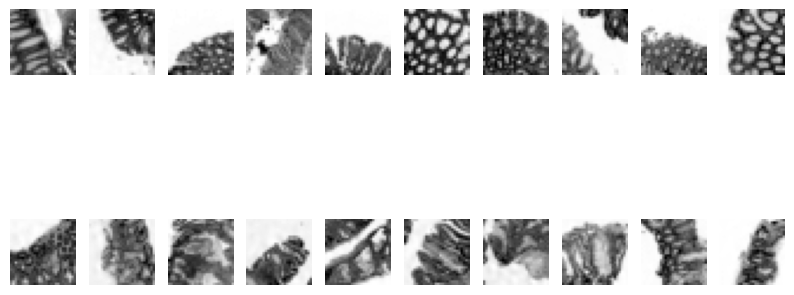

In [23]:
import matplotlib.pyplot as plt

# 显示每个类别的蒸馏图像
def visualize_distilled_images(distilled_images, num_classes, num_images_per_class):
    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(10, 5))
    for class_idx in range(num_classes):
        for img_idx in range(num_images_per_class):
            ax = axes[class_idx, img_idx]
            # 使用 .detach() 将梯度分离，转换为 CPU 并转换为 numpy 格式
            ax.imshow(distilled_images[class_idx * num_images_per_class + img_idx].cpu().detach().squeeze(), cmap='gray')
            ax.axis('off')
    plt.show()

# 可视化步骤1和步骤2生成的蒸馏数据集
visualize_distilled_images(distilled_images, num_classes=2, num_images_per_class=num_images_per_class)




迭代 1/10, 蒸馏损失: 0.6911438012123108
迭代 2/10, 蒸馏损失: 0.6910671806335449
迭代 3/10, 蒸馏损失: 0.6909911918640137
迭代 4/10, 蒸馏损失: 0.6909118795394897
迭代 5/10, 蒸馏损失: 0.6908321571350098
迭代 6/10, 蒸馏损失: 0.6907546186447143
迭代 7/10, 蒸馏损失: 0.6906786322593689
迭代 8/10, 蒸馏损失: 0.6905993509292603
迭代 9/10, 蒸馏损失: 0.6905212092399597
迭代 10/10, 蒸馏损失: 0.6904451084136963
Epoch 1/20, Loss: 0.6947820782661438
Epoch 2/20, Loss: 0.6776237487792969
Epoch 3/20, Loss: 0.6632900238037109
Epoch 4/20, Loss: 0.6489726901054382
Epoch 5/20, Loss: 0.6342173218727112
Epoch 6/20, Loss: 0.6185373067855835
Epoch 7/20, Loss: 0.6032124757766724
Epoch 8/20, Loss: 0.5873116254806519
Epoch 9/20, Loss: 0.5706574320793152
Epoch 10/20, Loss: 0.5536839365959167
Epoch 11/20, Loss: 0.5367148518562317
Epoch 12/20, Loss: 0.5194371342658997
Epoch 13/20, Loss: 0.5019485354423523
Epoch 14/20, Loss: 0.48432761430740356
Epoch 15/20, Loss: 0.4665854573249817
Epoch 16/20, Loss: 0.44842714071273804
Epoch 17/20, Loss: 0.4303057789802551
Epoch 18/20, Loss: 0

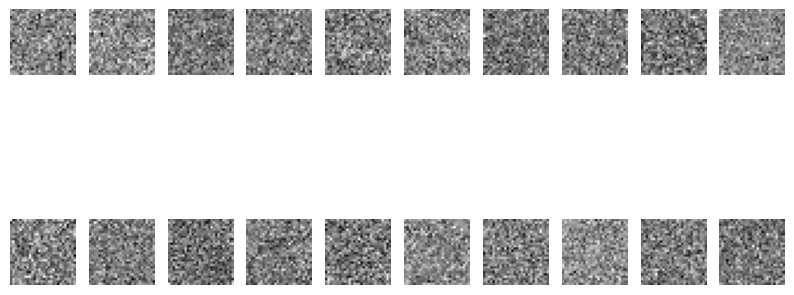

In [30]:
# Step 4: 用高斯噪声初始化蒸馏图像并从头开始蒸馏
# 符合 Task 1 的要求，用高斯噪声初始化以进行对比实验
distilled_images_gaussian = torch.randn((2 * num_images_per_class, 1, 28, 28), requires_grad=True, device=device)
distilled_labels_gaussian = torch.tensor([0] * num_images_per_class + [1] * num_images_per_class).to(device)
optimizer_images_gaussian = optim.SGD([distilled_images_gaussian], lr=lr_image)  # 使用与 S1-S3 相同的学习率

# 重新进行蒸馏过程，从头开始
T_gaussian = 10  # 可以设置为和 S1-S3 相同的迭代次数
distill_with_attention_matching(model_mhist, train_loader_mhist, distilled_images_gaussian, distilled_labels_gaussian, optimizer_images_gaussian, T=T_gaussian)

# 在蒸馏数据集上重新训练模型
model_mhist_gaussian = ConvNet7().to(device)  # 重新初始化模型，确保从头开始
train_on_distilled_data(model_mhist_gaussian, distilled_images_gaussian, distilled_labels_gaussian, epochs=20, lr=0.01)

# 定义 MHIST 测试集的 DataLoader（如果需要在真实测试集上评估）
test_dataset_mhist = MHISTDataset(annotations_file=annotations_file, img_dir=img_dir, transform=mhist_transform)
test_loader_mhist = DataLoader(test_dataset_mhist, batch_size=128, shuffle=False)

# 使用真实测试集进行评估
evaluate_model(model_mhist_gaussian, test_loader_mhist)


# 可视化用高斯噪声初始化的蒸馏数据
visualize_distilled_images(distilled_images_gaussian, num_classes, num_images_per_class)


In [33]:
import torch.nn as nn
import torch.optim as optim

# 定义新的网络架构（例如 LeNet）
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 根据你的类别数调整输出大小

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 使用合成数据集训练 LeNet 模型
def train_on_distilled_data_leNet(model, distilled_images, distilled_labels, epochs=20, lr=0.01):
    distilled_dataset = TensorDataset(distilled_images, distilled_labels)
    distilled_loader = DataLoader(distilled_dataset, batch_size=32, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in distilled_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(distilled_loader)}")

# 初始化 LeNet 模型并训练
model_leNet = LeNet().to(device)
train_on_distilled_data_leNet(model_leNet, distilled_images, distilled_labels, epochs=20, lr=0.01)

# 在真实测试集上评估 LeNet 模型
evaluate_model(model_leNet, test_loader_mhist)


Epoch 1/20, Loss: 2.3248231410980225
Epoch 2/20, Loss: 2.319262981414795
Epoch 3/20, Loss: 2.313723564147949
Epoch 4/20, Loss: 2.308201551437378
Epoch 5/20, Loss: 2.3026986122131348
Epoch 6/20, Loss: 2.297210454940796
Epoch 7/20, Loss: 2.291741371154785
Epoch 8/20, Loss: 2.286283254623413
Epoch 9/20, Loss: 2.2808384895324707
Epoch 10/20, Loss: 2.275399923324585
Epoch 11/20, Loss: 2.2699763774871826
Epoch 12/20, Loss: 2.2645726203918457
Epoch 13/20, Loss: 2.2591898441314697
Epoch 14/20, Loss: 2.2538297176361084
Epoch 15/20, Loss: 2.2484726905822754
Epoch 16/20, Loss: 2.2431235313415527
Epoch 17/20, Loss: 2.2377781867980957
Epoch 18/20, Loss: 2.2324330806732178
Epoch 19/20, Loss: 2.2270989418029785
Epoch 20/20, Loss: 2.221773624420166
真实测试集上的准确率: 68.59137055837563%
